# Emulate a Lorenz 96 model
The objective of this notebook is to provide a tutorial that emulates a Lorenz 63 model from data only.

The general objective of this work is to present a methodology that consider a time-series ${\bf v}_0,\cdots,{\bf v}_K$ and infer a data-driven model $G({\bf v}_k)$ such as
$$
{\bf x}_{k+1} \approx G({\bf x}_k,)
$$


## Importation and initializations
This section imports and define few utilities functions. You can execute the cells below and then goes directly to the part 1-data definition.

In [1]:
incolab=True
try:
  import colab
except:
  incolab = False

if incolab:
  print("This notebook runs under colab")
  !pip install wget
  import wget
  wget.download('https://raw.githubusercontent.com/nansencenter/ml-crashcourse/dev/utils.py')

In [2]:
## Before we start let's import few packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
from utils import simulate, plot_L96_2D, dt, rmse, Periodic1DPadding
from utils import forward_L96 as forward
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
## We initialize the random generators so the notebook is fully reproducible

np.random.seed(2021)
tf.random.set_seed(2022)


1. Data definition

The Lorenz 96 model is defined on a 40-dimensional state $\mathbf{x}(t)$ by the following equations:
\begin{align}
\frac{\mathrm{d}x_i}{\mathrm{d}t} &= (x_{i+1} - x_{i-2})x_{i-1} + F,

\end{align}
In our case we take the defaults values $F = 8$


We integrate the ODEs (Ordinary Differential Equations) using a runge kutta scheme on discrete time steps $t_k$ such as $t_{k+1}-t_k = \delta t = 0.01$ (by default). We denote $\mathcal{M}$ the inegretion operator (sometimes called the *resolvent*) over a time step $\delta t$, such as:
$$
{\bf x_{k+1}} = \mathcal{M}({\bf x_{k}})
$$


Now we are almost ready to generate all the data. We are defining all the necessary parameters (some of which will be explained later on). You can play with thoses parameters to see the effect of some of them (e.g. the size of the training set, or the noise of the training set).

In [4]:
M = 40 # size of the state
K = 50000 # size of the reference simulation
Ktrain=10000 # Number of samples in the training set
Kval = 5000 # Number of samples in the validation set
Ktest = 2000 # Number of samples in the test set (used to assess the forecast skill)
Ntest = 500 # Size of the test set ensemble
x0ref = np.zeros(M) # Reference point to initialize simulations
stdo = 0 #Relative noise on the data

Now, let's simulate the data for the reference set and the test set

In [5]:
#Reference dataset generation
x0 = x0ref + 1e-3*np.random.randn(M)
x = simulate(forward, K, x0)


# Define the noise field
sigma = np.std(x,axis=0)
noise = stdo*sigma*np.random.randn(K,M)

# Extract the training and validation set (add noise on the training)
Xtrain = x[0:Ktrain] +  noise[0:Ktrain]
ytrain = x[1:Ktrain+1] + noise[1:Ktrain+1]

Xval = x[Ktrain:Ktrain+Kval]
yval = x[Ktrain+1:Ktrain+Kval+1]
ttval = dt*(Ktrain+1)+ dt*np.arange(Kval)
# Test set (ensemble) generation
x0test = x0ref[np.newaxis,:] + 1e-3*np.random.randn(Ntest,M)
xtest = simulate(forward, Ktest, x0test, N=Ntest)
ttest = dt*np.arange(Ktest) #Time scale of the test datset

# Print the size
print(f'Size of the reference set: {x.shape}\nSize of the test set: {xtest.shape}')


Size of the reference set: (50000, 40)
Size of the test set: (2000, 500, 40)


**We recomend to always have a look at the dataset and its main characteristic, using simple visualization, before running any processing.**

We now plot the simulations of few time steps of one member of the test simulation

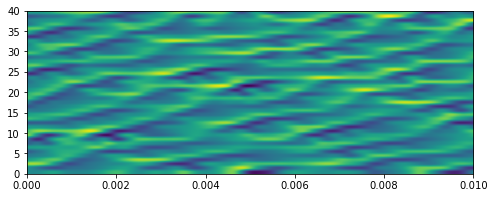

In [6]:
fig, ax = plt.subplots(figsize=(8,3))
ax.imshow(xtest[:600,1].T,extent=[ttest[0],ttest[1],0,M],aspect='auto')


Ater a transient period (model spinup), discarded in the simulations, the vector ${\bf x}$ takes value in a subspace of the $\mathbb{R}^3$, called the **model attractor**. We can represents in the density of  values of the attractor (plot in the phase space).

N.B. we use the python ```hist2d``` that "bin" the data to represent the density. Due to binning effect, the density in the edge of the attractor seems like discontinous points whereas the trajectory are continous

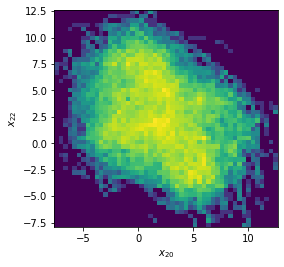

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist2d(x[...,20],x[...,22], bins=(50,50),  norm=mpl.colors.LogNorm(clip=True))
ax.set_xlabel('$x_{20}$')
ax.set_ylabel('$x_{22}$');

If we do the same phase plot but limited to training set, it can be seen that denser parts attractor are covered by the training set, but the edges (less frequent) are undersampled.

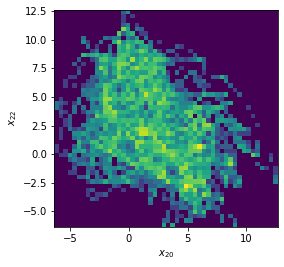

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist2d(Xtrain[...,20],Xtrain[...,22], bins=(50,50),  norm=mpl.colors.LogNorm(clip=True))
ax.set_xlabel('$x_{20}$')
ax.set_ylabel('$x_{22}$');

<span style="color:red">**OBJECTIVE OF THIS NOTEBOOK**</span> 

Given the dataset ${\bf v}_0,\cdots,{\bf v}_K$ in the training set, we want to determine a data driven model $G({\bf v}_k,\theta)$, such as:
$$
{\bf v}_{k+1} = G({\bf v}_k,\boldsymbol{\theta}) + \epsilon_k,
$$
where $\epsilon_k$ is the error of the data-driven model, $\boldsymbol{\theta}$ is the set of parameter of the data-driven model to be adjusted the the error is minimum. To achieve this objective, the following loss (also call cost function) is minimized:
$$
L(\boldsymbol{\theta}) = \sum_{k=1}^K \left[ {\bf v}_{k+1} - G({\bf v}_k,\boldsymbol{\theta}) \right]^2
$$.

If the data-driven model is perfect $L(\boldsymbol{\theta})=0$ and $G({\bf v}_k,\boldsymbol{\theta}) = \mathcal{M}({\bf v_{k}})$

<span style="color:red">**EVALUATION OF THE DATA-DRIVEN MODEL**</span> 

The model $G({\bf v}_k,\boldsymbol{\theta})$ is evaluated for 2 distincts properties:
1. **The forecast skill** Given the same initial condition ${\bf v}_0$, how far in time the prediction of the model is accurate, i.e. $G^h({\bf v}_0,\boldsymbol{\theta}) - \mathcal{M}^h({\bf v_{0}})$ is small? This property is evaluated by commputing the root-mean square error in time over an ensemble of indepednant initial conditions (the size of the ensemble is given by the variable ```Ntest```
2. **The climate of the model** If we integrate the data-driven model over a long time, how good the attractor is reproduced? This property is assessed by comparing qualitatively the atttractor of the true model and the data-driven model.

*N.B. In this notebook, we only present a few assessments of the performances. There are of course a large variety of scores to asssess the quality of the data-driven model (e.g. Lyapunov exponents, energy spectrum, ...). The following papers give example of complete assessment that can be done on a data-driven model.See for example:*
- Pathak, Jaideep, et al. "Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data." Chaos: An Interdisciplinary Journal of Nonlinear Science 27.12 (2017): 121102. https://aip.scitation.org/doi/full/10.1063/1.5010300?casa_token=zAZf0spCswoAAAAA:KsWSuFIGVCVvKSvV5U225tD_W1sn0bRF4G-0weOFXNwx0-v80d-NhcMMRivIj6VFdZ704S7ePiBh

- Brajard, Julien, et al. "Combining data assimilation and machine learning to emulate a dynamical model from sparse and noisy observations: a case study with the Lorenz 96 model." Journal of Computational Science 44 (2020): 101171.
https://www.sciencedirect.com/science/article/pii/S1877750320304725?casa_token=1TZhvVKQx8AAAAAA:lKVvhP7Wg7cILKQNSXlpdXXXKxrt_RVlUn1VJLRUlSCSAm1f4bOuMId2EMRVHLhW-qkb8-DS3w4

## 2. A simple baseline
Before designing any complex (or even not so complex) machine learning approach, it is recommended to test a **simple and naive baseline**. Here we try a simple **linear model** as a very simple data-driven model.


First, The linear model is fitted on the training dataset:

In [9]:
reg = LinearRegression().fit(Xtrain, ytrain)


Second, the predictions for the validation dataset are computed.

In [10]:
ylin = reg.predict(Xval)

Then, the true values are compared with the linear prediction

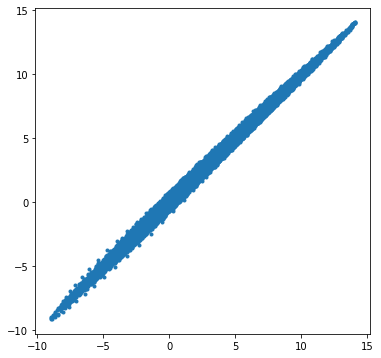

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(yval.ravel(),ylin.ravel(),'.')

It seems that the linear model does a pretty good job here. But the scatter plots show only the error after an integration of a small time increment $\Delta t$. We need to assess the skill of the model used on a longer time (for the forecast and the reproduction of the climate)

So we compute the forecast of the linear model with the same ensemble of initial condition as the test dataset:

In [12]:
xtestlin = simulate(reg.predict, Ktest, xtest[0], N=Ntest,burnin=0)


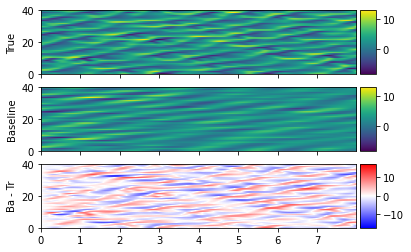

In [13]:
fig, ax = plot_L96_2D(xtest[:800,1],xtestlin[:800,1],ttest[:800], ('True','Baseline'))

On the previous example, it can be seen that the linear model shows only quasi periodic wave propagation, that have a very limited forecast skill. Let's have a look at the forecast skill averaged over the 500 examples of the dataset

In [14]:
rmse_lin = rmse(xtest, xtestlin, axis=(1,2))

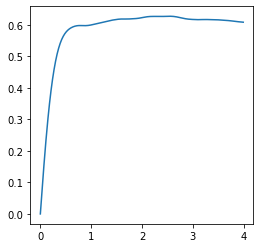

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ttest[:400],rmse_lin[:400])

There is not much we can conclude from the previous figure. We see that the error reaches 60% after .75 times for $x$.
It gives a baseline our data-driven model needs outperform.

Now we can also have a look at the climate reconstruction by plotting the attractor of the linear data-driven model:

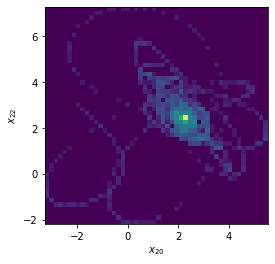

In [16]:
xtestlinlong = simulate(reg.predict, K, xtest[0,:1], burnin=0, N=1).squeeze()
fig, ax = plt.subplots(figsize=(4,4))
ax.hist2d(xtestlinlong[...,20],xtestlinlong[...,22], bins=(50,50),  norm=mpl.colors.LogNorm(clip=True))
ax.set_xlabel('$x_{20}$')
ax.set_ylabel('$x_{22}$');


The model is converging to a single fixed point, which is very different from the expected attractor.

## 2. The neural network emulator
First, let's define the list of parameters for the neural network. Don't hesitate to play with the parameters to see the effect of each of them.
If ```stoch``` is set to ```True```, an additionnal neural net simulating a Gaussian is also trained and compared with the deterministic neural network (see the description below). If ```stoch```is set to false. Ignore all the comments in <span style="color:blue">blue</span> 


In [17]:
stoch = False
norm_input = True #Standardization of the input vector
nhid1 = 50 # Number of filters in the first hidden layer
nhid2 = 30 # Number of filters in the second hiddent layer
filter1 = 5 # Filter size for the first layer
filter2 = 1 # Filter size of the second layer
epochs = 40 # Number of epochs during optimization
optimizer = 'Adam'# Optimizer used for the training


Compute the normalization of the input:

In [18]:
if norm_input:
    mean_ = np.mean(Xtrain,axis=(0,1),keepdims=True)
    std_= np.std(Xtrain,axis=(0,1), keepdims=True)
    norm = lambda x: (x-mean_)/std_
    denorm = lambda x: x*std_ + mean_
else:
    norm = lambda x: x
    denorm = lambda x: x

Define the deterministic neural network model



In [19]:
inputs = keras.Input(shape=(M,1))
border= (filter1//2+filter2//2)
lay = Periodic1DPadding(padding_size=border)(inputs)
lay = layers.Conv1D(nhid1, filter1, activation='tanh')(lay)
lay = layers.Conv1D(nhid2, filter2, activation='tanh')(lay)
outputs = layers.Conv1D(1,1)(lay)
nn_model_det = keras.Model(inputs=inputs, outputs=outputs, name='deterministic_L96')
nn_model_det.compile(optimizer=optimizer, loss='mse')
nn_model_det.summary()

Model: "deterministic_L96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 1)]           0         
_________________________________________________________________
periodic1d_padding (Periodic (None, 44, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 50)            300       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 30)            1530      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 1)             31        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


<font color='blue'>

**Gaussian version (with mean and standard devation as output)**

We can interpret the loss function as a maximum of likelihood if we make the hypothosesis that the observationfollows a Gaussian law:

$$
p(y/x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp -\frac{(y - \mu(x))^2}{2\sigma^2}
$$
where $x$ is observed, and $\mu(x)$ represents the mean of the gaussian depending on $x$.
This is a general formula, expressed for simplicity in the scalar case. In our case, we have $x = {\bf x}_k$ and $y = {\bf x}_{k+1}$

Given a set of samples $(x_k,y_k)_{1:K}$, maximizing the likelihood (i.e. finding an estimation so that the observation is the more probable) consist in minimizing the negative log-likelihood:
$$
L = \sum_{k=1}^{K} \left(\frac{\log 2\pi\sigma^2}{2} + \frac{(y_k - \mu(x_k))^2}{2\sigma^2}\right)
$$

1. **Deterministic case**: $\mu(x) \approx G_\mu(x,{\boldsymbol \theta}_\mu)$ 
We try to identify the parameters of the neural net ${\boldsymbol \theta}_\mu$ that minimze L. As the first term and the denominator of L are a constant (do not depend on ${\boldsymbol \theta}_\mu$), we equivalentely minimize:
$$
L({\boldsymbol \theta}_\mu) =  \sum_{k=1}^{K} (y_k - G_\mu(x,{\boldsymbol \theta}_\mu))^2
$$
which is exactly the mean square loss already introduced.


2. **Gaussian case**: $\mu(x) \approx G_\mu(x_k,{\boldsymbol \theta}_\mu)$  and $\sigma(x) \approx G_\sigma(x,{\boldsymbol \theta}_\sigma)$
We now assume that the standard deviation depends also on $x$ and that we parameterize it by another neural network.
So we can estimate both the parameters of the neural net for the mean $\mu$ and the standard deviation $\sigma$ by minimizing:
$$
L({\boldsymbol \theta}_\mu, {\boldsymbol \theta}_\sigma) = \sum_{k=1}^{K} \left(\frac{\log 2\pi G_\sigma(x_k,{\boldsymbol \theta}_\sigma)^2}{2} + \frac{(y_k - G_\mu(x_k,{\boldsymbol \theta}_\mu))^2}{2 G_\sigma(x_k,{\boldsymbol \theta}_\sigma)^2}\right)
$$
This way the neural net $G=(G_\mu,  G_\sigma)$ gives not only an estimation of the output but also the uncertainty of this estimation in the form of the standard deviation.
    </font>


In [20]:
def loss_mle(y_true, y_pred):
	# scale predictions so that the class probas of each sample sum to 1
	mean_true = y_true
	mean_pred, std_pred = y_pred[...,0], y_pred[...,1]
	# Max to prevent NaN's and Inf's
	log_std = tf.math.log(tf.maximum(std_pred,tf.math.sqrt(tf.keras.backend.epsilon())))
	sq_std = tf.maximum(tf.square(std_pred),tf.keras.backend.epsilon() )
	mse = tf.math.squared_difference(mean_pred, mean_true) / (2*sq_std)
	loss = log_std + mse
	loss = tf.reduce_sum(loss, -1)
	return loss
if stoch:
	inputs = keras.Input(shape=(M,1))
	border= (filter1//2+filter2//2)
	lay = Periodic1DPadding(padding_size=border)(inputs)
	lay = layers.Conv1D(nhid1, filter1, activation='tanh')(lay)
	lay = layers.Conv1D(nhid2, filter2, activation='tanh')(lay)
	mu = layers.Conv1D(1,1)(lay)
	sigma = layers.Conv1D(1,1, activation='exponential')(lay)
	outputs = layers.Concatenate(name='output')([mu, sigma])

	nn_model_gauss = keras.Model(inputs=inputs, outputs=outputs, name='gaussian_L96')
	nn_model_gauss.summary()
	#Need a special loss


	nn_model_gauss.compile(optimizer=optimizer, loss=loss_mle)




It is now possible de train the model (optimize the parameters)

First we train the deterministic model

In [21]:
history_d = nn_model_det.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=epochs)


Epoch 1/40
313/313 [==============================] - 1s 4ms/step - loss: 5.8413 - val_loss: 0.1877
Epoch 2/40
313/313 [==============================] - 1s 3ms/step - loss: 0.1631 - val_loss: 0.1170
Epoch 3/40
313/313 [==============================] - 1s 2ms/step - loss: 0.1036 - val_loss: 0.0747
Epoch 4/40
313/313 [==============================] - 1s 2ms/step - loss: 0.0657 - val_loss: 0.0441
Epoch 5/40
313/313 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0220
Epoch 6/40
313/313 [==============================] - 1s 3ms/step - loss: 0.0178 - val_loss: 0.0108
Epoch 7/40
313/313 [==============================] - 1s 2ms/step - loss: 0.0094 - val_loss: 0.0062
Epoch 8/40
313/313 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 9/40
313/313 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 10/40
313/313 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0024

Before assessing the performance of the NN model, we have look at the loss decreasing over the epochs for the training dataset and the validation dataset. The training loss is expected to decrease during the training (if not, it denotes a very serious problem on the data or on the model). It is also important to verify that the validation loss is also decrasing, otherwise it can reveal that the NN model is **overfitting** on the data.

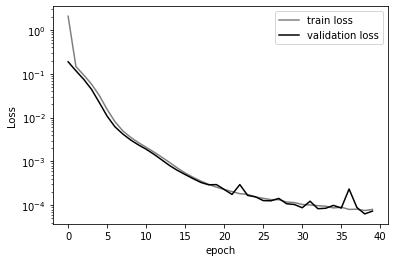

In [22]:
fig, ax = plt.subplots()
ax.semilogy(history_d.history['loss'],color='gray',label='train loss')
ax.semilogy(history_d.history['val_loss'],color='black',label='validation loss')
ax.legend()
ax.set_xlabel('epoch');
ax.set_ylabel('Loss');

<font color='blue'>
We now train the stochastic model</font>

In [23]:
if stoch:
  history_s = nn_model_gauss.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=epochs)

  fig, ax = plt.subplots()
  ax.plot(history_s.history['loss'],color='gray',label='train loss')
  ax.plot(history_s.history['val_loss'],color='black',label='validation loss')
  ax.legend()
  ax.set_xlabel('epoch');
  ax.set_ylabel('Loss');

Prediction of the model on the validation set:

In [24]:
ynn_det = nn_model_det.predict(norm(Xval))
if stoch:
	ynn_sto = nn_model_gauss.predict(norm(Xval))


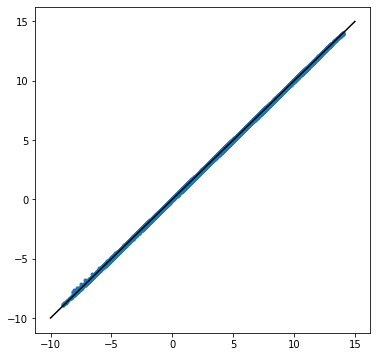

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(yval.ravel(),ynn_det[...,0].ravel(),'.', label='NN')

if stoch:
	ax.plot(yval.ravel(),ynn_sto[...,0].ravel(),'.', alpha=.5,label='NN stoch.')
	ax.legend()
ax.plot([-10,15],[-10,15],'-k');

The scatter plots looks almost perfect. But remember that they were also looking good for the linear model baseline. This shows only the skill of the NN model adter a short $\Delta t$ time step. Now we need to assess the NN model on longer time.

<font color='blue'>
The three next cells are run only if the stochastic model is trained. It allows to compare the actual error of the neural net with
the estimated standard deviation.

First we compare the all state:</font>

In [26]:
if stoch:
    Nt = 800

    fig, ax = plt.subplots(nrows=2,figsize=(10,6),sharex='all')
    d1 = ax[0].imshow(np.abs(yval[:Nt].T-ynn_sto[:Nt,:,0].T),extent=[ttval[0],ttval[Nt],0,M],aspect='auto',cmap='jet',vmax=.1)
    d2 = ax[1].imshow(ynn_sto[:Nt,:,1].T,extent=[ttval[0],ttval[Nt],0,M],aspect='auto',cmap='jet',vmax=.1)
    fig.colorbar(d1, ax=ax, orientation='vertical');

Now we compare only one coordinate (15)

In [27]:
if stoch:
    Nt = 2000
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(ttval[:Nt],np.abs(yval[:Nt,15]-ynn_sto[:Nt,15,0]), label='True error')
    ax.plot(ttval[:Nt],np.abs(ynn_sto[:Nt,15,1]), label='Estimated std')


<font color='blue'>
The normalized distribution of the errors is expected to be a Gaussian of mean zero ans standard deviation. We can see there is still a bias.</font>


In [28]:
if stoch:
    delta = (yval[:Nt]-ynn_sto[:Nt,:,0])/ynn_sto[:Nt,:,1]
    plt.hist(delta.ravel(),bins=100, density=True)
    xx = np.arange(-4,4,.01)
    yy = 1/(np.sqrt(2 * np.pi)) * np.exp( - xx**2 / 2)
    plt.plot(xx,yy)
    plt.xlim((-4,4));


Define the resolvant of the NN nodel. We have 3 resolvants:
- The output of the determistic neural net ```forward_d```
- <font color='blue'> The average of the gaussian neural net: ```forward_sd```</font>
- <font color='blue'> The average of the  gaussian neural net perturbed by a random noise of with the standard deviation given by the
neural net: ```forward_ss```</font>

In [29]:
forward_d = lambda v: nn_model_det(norm(v), training=False)[...,0]

if stoch:
	forward_sd = lambda v: nn_model_gauss(norm(v), training=False)[...,0]
	def forward_ss(v):
		epsi = np.random.randn(M)
		y = nn_model_gauss(norm(v), training=False)
		return  y[...,0] + epsi*y[...,1]

Integrate the NN model over the test dataset and plot one trajectory


In [30]:
xtestnn_d = simulate(forward_d, Ktest, xtest[0], M=M, N=Ntest,burnin=0)
if stoch:
	xtestnn_sd = simulate(forward_sd, Ktest, xtest[0], M=M, N=Ntest,burnin=0)
	xtestnn_ss = simulate(forward_ss, Ktest, xtest[0], M=M, N=Ntest,burnin=0)

Now we can plot the simulation of each of the simulations

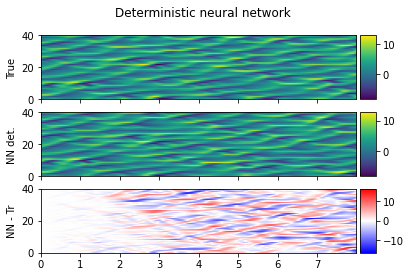

In [31]:
fig, ax = plot_L96_2D(xtest[:800,1],xtestnn_d[:800,1],ttest[:800], ('True','NN det.'))
fig.suptitle('Deterministic neural network')

if stoch:
	fig, ax = plot_L96_2D(xtest[:800,1],xtestnn_sd[:800,1],ttest[:800], ('True','NN stoch mean'))
	fig.suptitle('Mean of the stochastic neural network')

	fig, ax = plot_L96_2D(xtest[:800,1],xtestnn_ss[:800,1],ttest[:800], ('True','NN stoch perturbed'))
	fig.suptitle('Perturbed mean of the stochastic neural network')


It is clear that the NN model(s) "follows" the true simulation for a longer time than the baseline does,
and also the simulation is very similar to the true simulation. Note here that, due to the chaotic nature of the dynamic,
 any model model is expected to diverge with respect to the truth.

Now we can assess the forecast skill and compare it to the forecast skill of our linear model baseline.

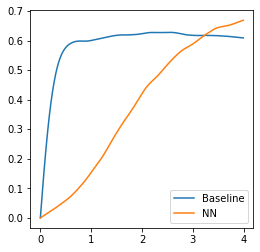

In [32]:
rmse_nn_d = rmse(xtest, xtestnn_d, axis=(1,2))
if stoch:
	rmse_nn_sd = rmse(xtest, xtestnn_sd, axis=(1,2))
	rmse_nn_ss = rmse(xtest, xtestnn_ss, axis=(1,2))

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ttest[:400],rmse_lin[:400], label='Baseline')
ax.plot(ttest[:400],rmse_nn_d[:400], label= 'NN')
if stoch:
	ax.plot(ttest[:400],rmse_nn_sd[:400], label= 'NN stoch. mean.')
	ax.plot(ttest[:400],rmse_nn_ss[:400], label= 'NN stoch. perturb.')

ax.legend();

It is very clear that the NN model outperforms the linear model. The error stays under 60% for more than 2 time units instead of 0.25 for the linear model, so the horizon of prediction has been roughly improve by a factor 4.

Finally, let's assess the long-term properties of the NN model.We make a long simulation of the NN model and visualize the attractor

In [33]:
print('Simulation deterministic')
xtestnnlong_d = simulate(forward_d, K, xtest[0,:1], burnin=0, N=1).squeeze()
if stoch:
	print('Simulation stochastic mean')
	xtestnnlong_sd = simulate(forward_sd, K, xtest[0,:1], burnin=0, N=1).squeeze()

	print('Simulation stochastic perturb')
	xtestnnlong_ss = simulate(forward_ss, K, xtest[0,:1], burnin=0, N=1).squeeze()


Simulation deterministic


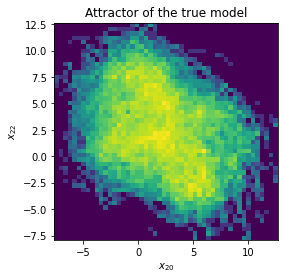

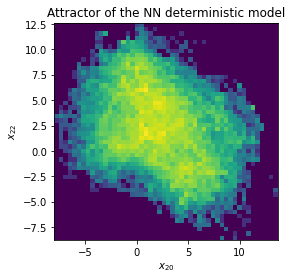

In [34]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist2d(x[...,20],x[...,22], bins=(50,50),  norm=mpl.colors.LogNorm(clip=True))
ax.set_xlabel('$x_{20}$')
ax.set_ylabel('$x_{22}$');
ax.set_title('Attractor of the true model')


fig, ax = plt.subplots(figsize=(4,4))
ax.hist2d(xtestnnlong_d[...,20],xtestnnlong_d[...,22], bins=(50,50),  norm=mpl.colors.LogNorm(clip=True))
ax.set_xlabel('$x_{20}$')
ax.set_ylabel('$x_{22}$');
ax.set_title('Attractor of the NN deterministic model')

if stoch:
	fig, ax = plt.subplots(figsize=(4,4))
	ax.hist2d(xtestnnlong_sd[...,20],xtestnnlong_sd[...,22], bins=(50,50),  norm=mpl.colors.LogNorm(clip=True))
	ax.set_xlabel('$x_{20}$')
	ax.set_ylabel('$x_{22}$');
	ax.set_title('Attractor of the NN stochastic model mean')

	fig, ax = plt.subplots(figsize=(4,4))
	ax.hist2d(xtestnnlong_ss[...,20],xtestnnlong_ss[...,22], bins=(50,50),  norm=mpl.colors.LogNorm(clip=True))
	ax.set_xlabel('$x_{20}$')
	ax.set_ylabel('$x_{22}$');
	ax.set_title('Attractor of the perturbed NN stochastic model mean')

The attractor of the NN model is very close to the attractor of the true model.